# Description

**The task**: Classify diabetes cases based on a dataset containing medical records.

**Methodology**

To build a robust classification model, this notebook employs:

- CatBoost: A gradient boosting algorithm optimized for categorical features and complex datasets.
- Optuna: A hyperparameter optimization framework to enhance model performance.
- MLflow: A tracking system for managing experiments, logging results, and comparing models.


# Importing libraries and loading the dataset

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import optuna
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
import shap

In [17]:
df = pd.read_csv("diabetes_dataset.csv")

In [18]:
df.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


In [19]:
df.columns

Index(['Age', 'Pregnancies', 'BMI', 'Glucose', 'BloodPressure', 'HbA1c', 'LDL',
       'HDL', 'Triglycerides', 'WaistCircumference', 'HipCircumference', 'WHR',
       'FamilyHistory', 'DietType', 'Hypertension', 'MedicationUse',
       'Outcome'],
      dtype='object')

In [20]:
print("\n🔹 Dataset Shape:", df.shape)
print("\n🔹 Column Info:")
print(df.info())


🔹 Dataset Shape: (9538, 17)

🔹 Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9538 non-null   int64  
 1   Pregnancies         9538 non-null   int64  
 2   BMI                 9538 non-null   float64
 3   Glucose             9538 non-null   float64
 4   BloodPressure       9538 non-null   float64
 5   HbA1c               9538 non-null   float64
 6   LDL                 9538 non-null   float64
 7   HDL                 9538 non-null   float64
 8   Triglycerides       9538 non-null   float64
 9   WaistCircumference  9538 non-null   float64
 10  HipCircumference    9538 non-null   float64
 11  WHR                 9538 non-null   float64
 12  FamilyHistory       9538 non-null   int64  
 13  DietType            9538 non-null   int64  
 14  Hypertension        9538 non-null   int64  
 15  Medication

# Basic EDA

In [21]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df = missing_df[missing_df["Missing Values"] > 0]  # Show only features with missing values
print("\n🔹 Missing Values:\n", missing_df)


🔹 Missing Values:
 Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


In [22]:
df.describe()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
count,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000,9538.000000
mean,53.577584,7.986161,27.052364,106.104183,84.475781,4.650661,100.133456,49.953418,151.147746,93.951678,103.060621,0.917400,0.302474,0.486161,0.001048,0.405012,0.344097
std,20.764651,4.933469,5.927955,21.918590,14.123480,0.476395,29.911910,15.242194,48.951627,15.594468,13.438827,0.140828,0.459354,0.661139,0.032364,0.490920,0.475098
min,18.000000,0.000000,15.000000,50.000000,60.000000,4.000000,-12.000000,-9.200000,50.000000,40.300000,54.800000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,4.000000,22.870000,91.000000,74.000000,4.300000,80.100000,39.700000,117.200000,83.400000,94.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,8.000000,27.050000,106.000000,84.000000,4.600000,99.900000,50.200000,150.550000,93.800000,103.200000,0.910000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72.000000,12.000000,31.180000,121.000000,94.000000,5.000000,120.200000,60.200000,185.100000,104.600000,112.100000,1.010000,1.000000,1.000000,0.000000,1.000000,1.000000
max,89.000000,16.000000,49.660000,207.200000,138.000000,6.900000,202.200000,107.800000,345.800000,163.000000,156.600000,1.490000,1.000000,2.000000,1.000000,1.000000,1.000000


In [23]:
print("\n🔹 Duplicate Rows:", df.duplicated().sum())


🔹 Duplicate Rows: 0


**Target distribution**

C:\Users\37529\AppData\Local\Temp\ipykernel_19388\326195699.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='Set2')


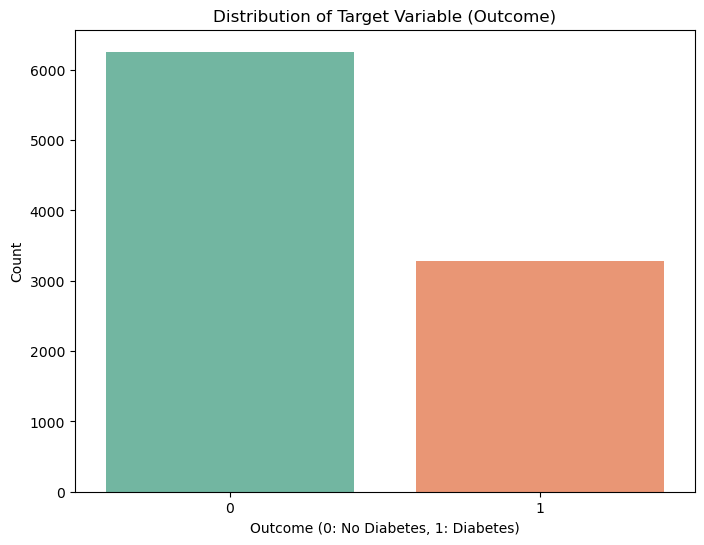

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Distribution of Target Variable (Outcome)')
plt.xlabel('Outcome (0: No Diabetes, 1: Diabetes)')
plt.ylabel('Count')
plt.show()

**Checking feature distributions**

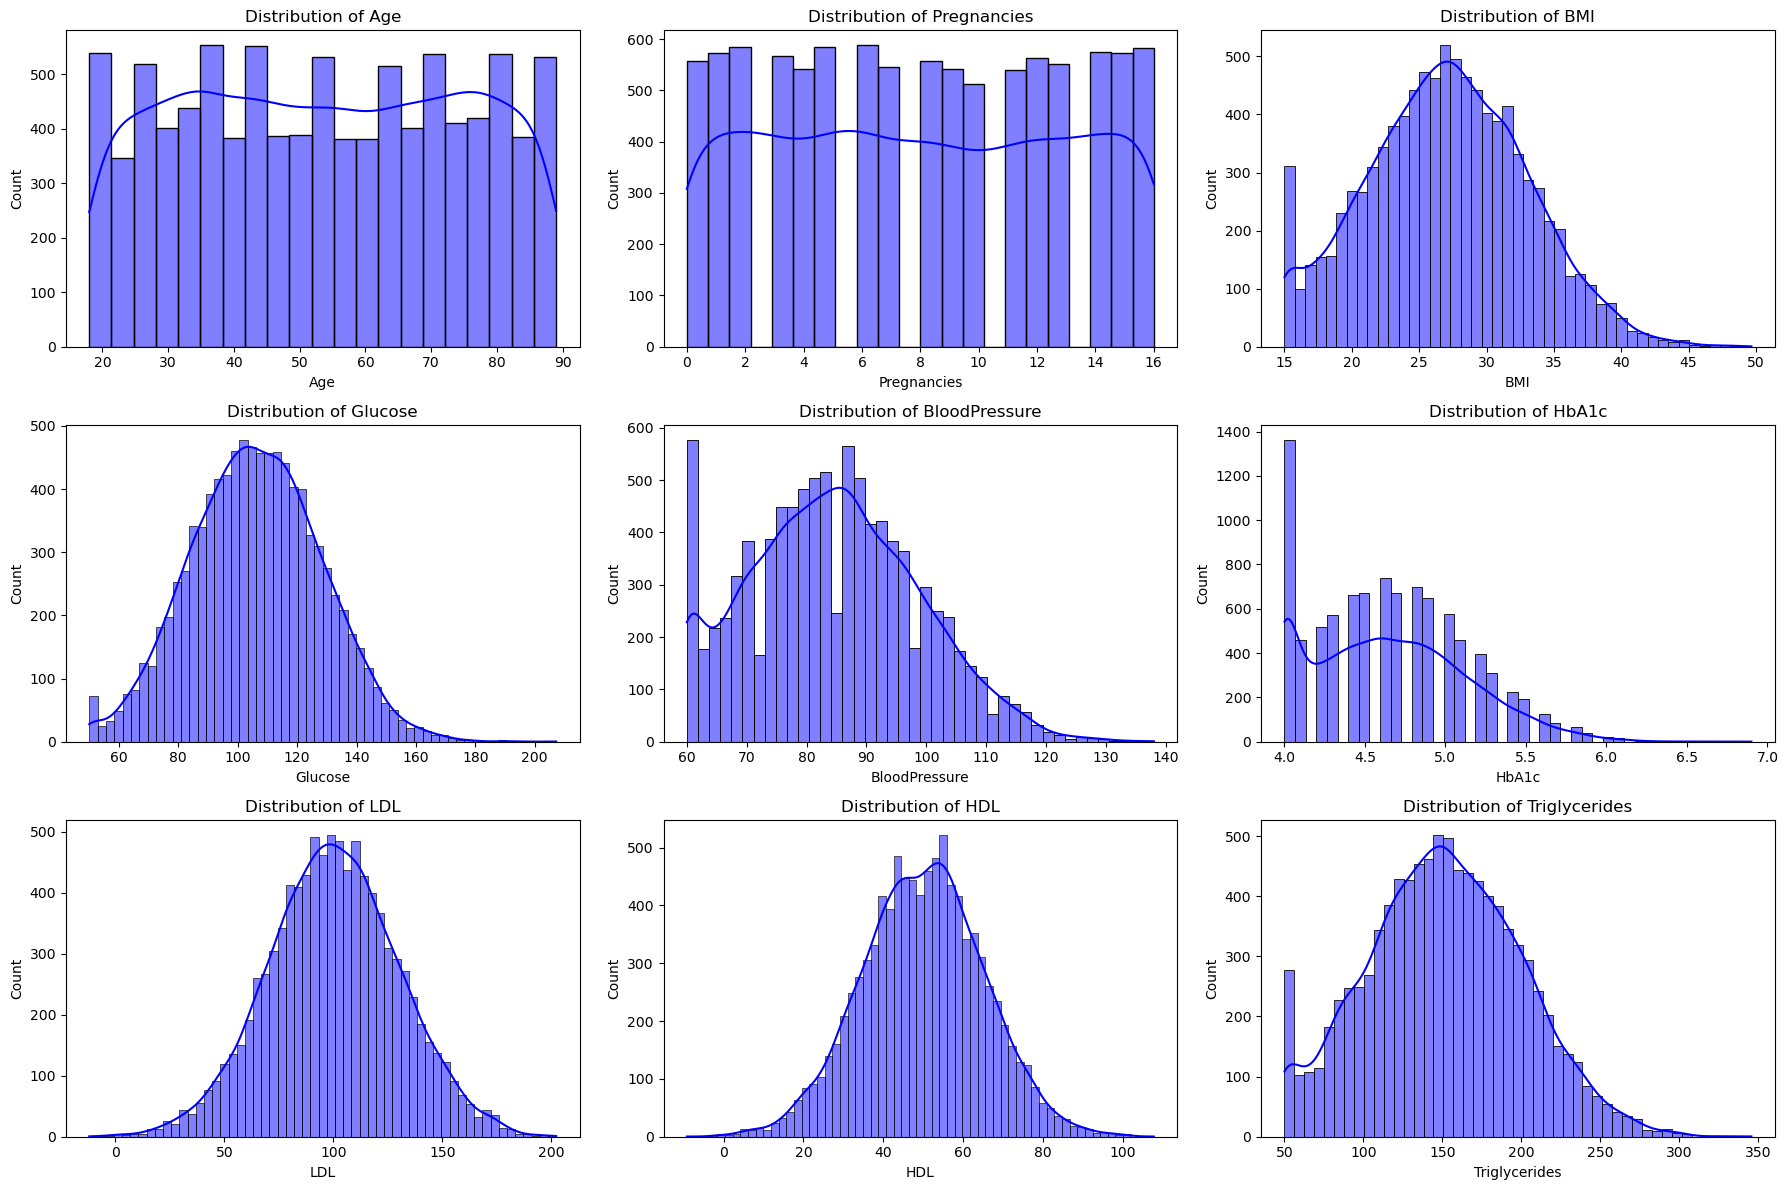

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))  # Adjust grid based on number of features
axes = axes.flatten()

for i, column in enumerate(df.columns[:9]):  
    if df[column].dtype == 'object':  # Categorical
        sns.countplot(data=df, x=column, ax=axes[i], palette="viridis")
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")
    else:  # Numerical
        sns.histplot(df[column], kde=True, ax=axes[i], color="blue")
    
    axes[i].set_title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

**Checking the relationship between features and target**

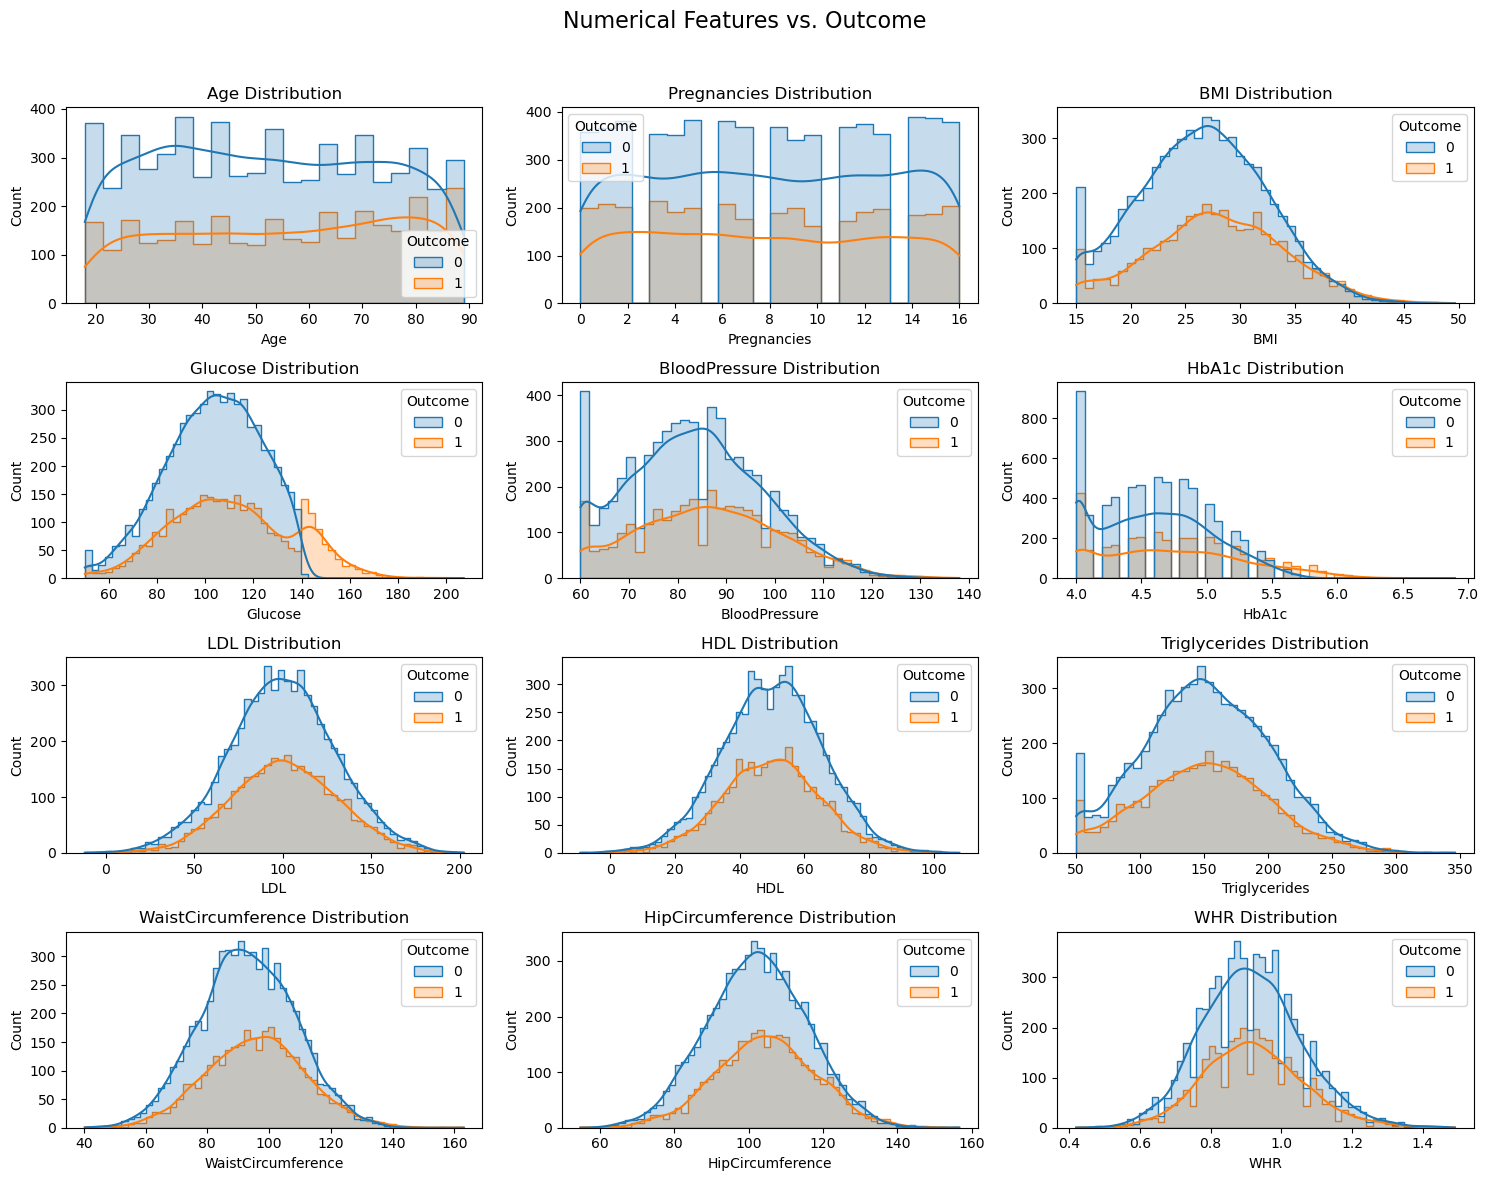

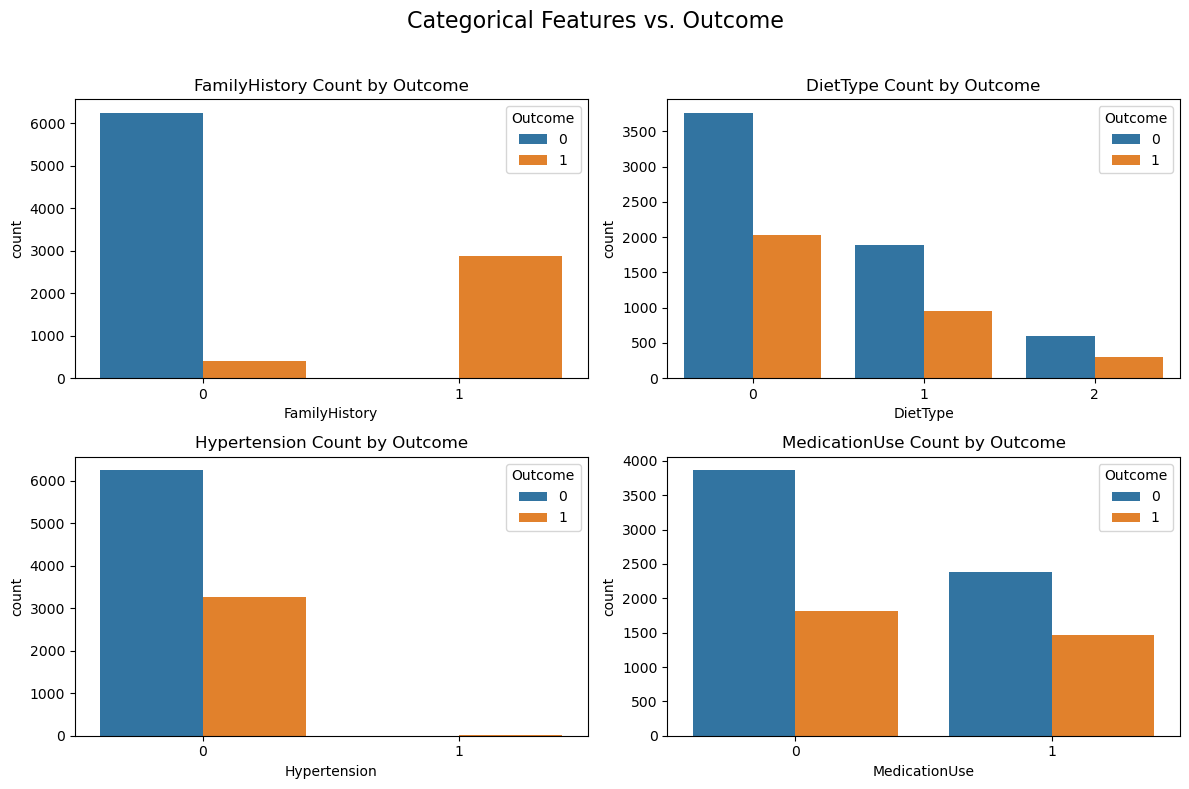

In [26]:
num_features = [
    "Age", "Pregnancies", "BMI", "Glucose", "BloodPressure", "HbA1c",
    "LDL", "HDL", "Triglycerides", "WaistCircumference", "HipCircumference", "WHR"
]
cat_features = ["FamilyHistory", "DietType", "Hypertension", "MedicationUse"]

# Plot numerical feature distributions by Outcome
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
fig.suptitle("Numerical Features vs. Outcome", fontsize=16)

for i, feature in enumerate(num_features):
    row, col = divmod(i, 3)
    sns.histplot(data=df, x=feature, hue="Outcome", element="step", kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"{feature} Distribution")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot categorical feature distributions by Outcome
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Categorical Features vs. Outcome", fontsize=16)

for i, feature in enumerate(cat_features):
    row, col = divmod(i, 2)
    sns.countplot(data=df, x=feature, hue="Outcome", ax=axes[row, col])
    axes[row, col].set_title(f"{feature} Count by Outcome")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Correlation matrix**

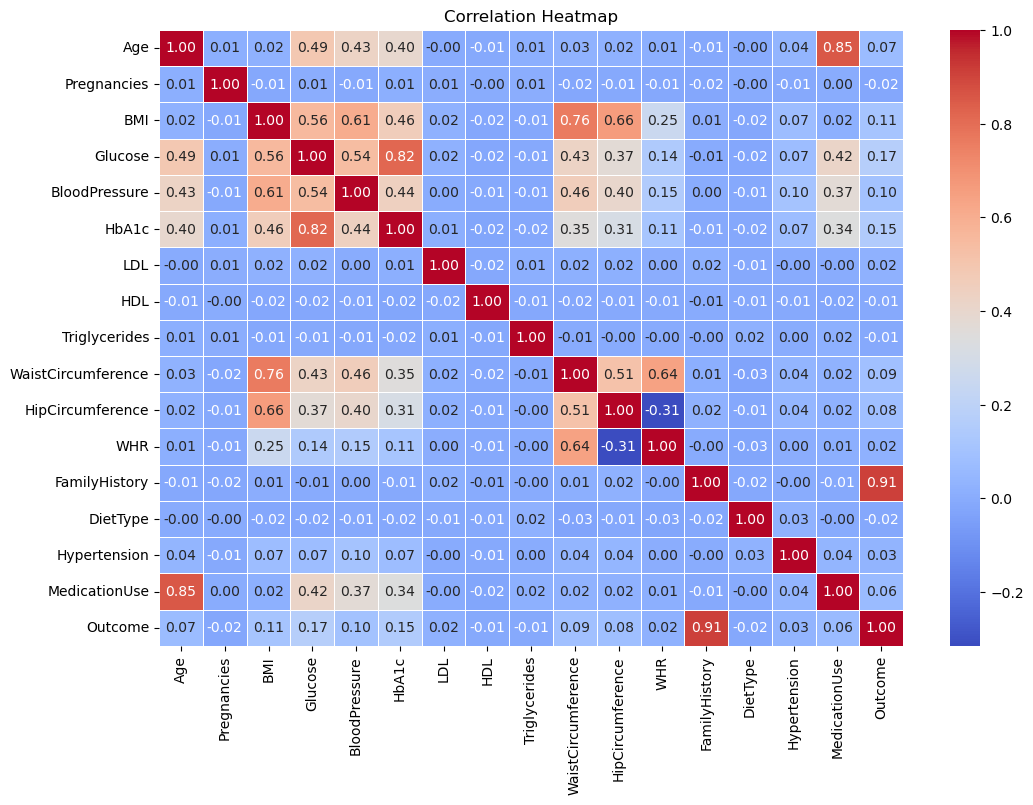

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Modeling with Catboost

**Splitting the data into train, val and test**

In [59]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

train_pool = Pool(X_train, y_train, cat_features=[])  
val_pool = Pool(X_val, y_val, cat_features=[])       
test_pool = Pool(X_test, y_test, cat_features=[])    

In [62]:
train_set = set(X_train.index)
test_set = set(X_test.index)
overlap = train_set.intersection(test_set)
print(f"Overlapping rows: {overlap}")

Overlapping rows: set()


**Optuna and MLFlow**

In [45]:
mlflow.set_tracking_uri("file:///D:/Week3/mlruns")

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.05, 1),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        #'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        #'verbose': False,
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.log_metrics({
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
        })

    return roc_auc  

mlflow.set_experiment("CatBoost_Diabetes_Classification")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = CatBoostClassifier(**best_params, verbose=False)
final_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

# Log the final model to MLFlow with signature and input example
with mlflow.start_run():
    mlflow.log_params(best_params)

    input_example = X_test.iloc[0:1]  

    signature = infer_signature(X_test, final_model.predict(X_test))

    mlflow.sklearn.log_model(
        final_model,
        "catboost_model",
        signature=signature,
        input_example=input_example,
    )

**Cross-validation**

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'depth': trial.suggest_int('depth', 3, 8),  
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 10),  
        'subsample': trial.suggest_float('subsample', 0.5, 1),  
        'random_strength': trial.suggest_float('random_strength', 0.1, 5),  
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),  
        'loss_function': 'Logloss',  
        'verbose': False,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'f1': [], 'roc_auc': []}

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool_fold = Pool(X_train_fold, y_train_fold, cat_features=[])
        val_pool_fold = Pool(X_val_fold, y_val_fold, cat_features=[])

        model = CatBoostClassifier(**params)
        model.fit(
            train_pool_fold,
            eval_set=val_pool_fold,
            early_stopping_rounds=50,  
            verbose=False
        )

        y_pred = model.predict(X_val_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        scores['f1'].append(f1_score(y_val_fold, y_pred))
        scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba))

    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        mlflow.log_metrics({
            'mean_accuracy': np.mean(scores['accuracy']),
            'mean_f1_score': np.mean(scores['f1']),
            'mean_roc_auc': np.mean(scores['roc_auc']),
        })

    return np.mean(scores['roc_auc'])

mlflow.set_experiment("CatBoost_Diabetes_Classification")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


final_model = CatBoostClassifier(**best_params, verbose=False)
final_model.fit(
    train_pool,
    eval_set=val_pool,  # Use the validation set for early stopping
    early_stopping_rounds=50,  
    verbose=False
)

y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)

with mlflow.start_run():
    mlflow.log_params(best_params)

    mlflow.log_metrics({
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1,
        'test_roc_auc': test_roc_auc,
    })

    input_example = X_test.iloc[0:1]  
    signature = infer_signature(X_test, final_model.predict(X_test))
    mlflow.sklearn.log_model(
        final_model,
        "catboost_model",
        signature=signature,
        input_example=input_example,
    )

In [92]:
print("Classification Report:\n")
print(classification_report(y_test, y_test_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       939
           1       1.00      1.00      1.00       492

    accuracy                           1.00      1431
   macro avg       1.00      1.00      1.00      1431
weighted avg       1.00      1.00      1.00      1431



In [63]:
train_f1 = f1_score(y_train, final_model.predict(X_train))
val_f1 = f1_score(y_val, final_model.predict(X_val))
test_f1 = f1_score(y_test, final_model.predict(X_test))

print(f"Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

Train F1: 0.9993, Validation F1: 0.9990, Test F1: 1.0000


**Confusion matrix**

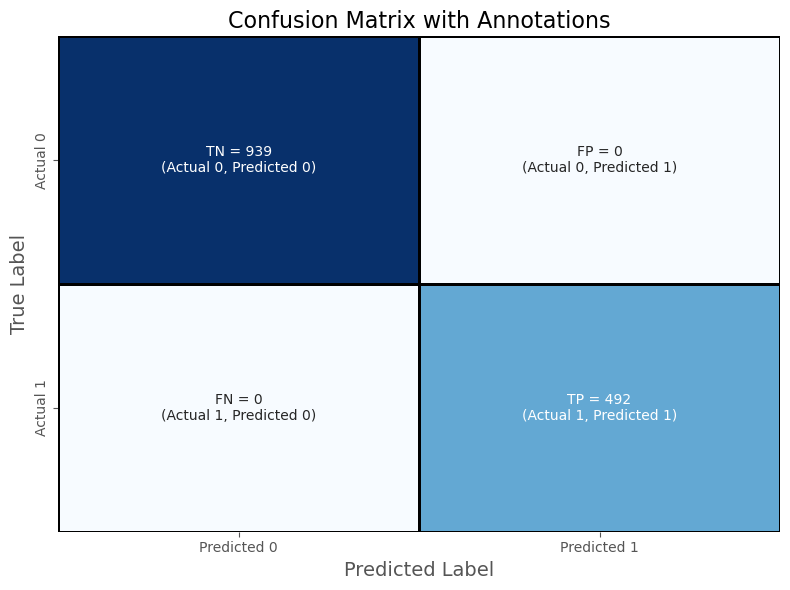

In [ ]:
y_test_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)

labels = np.array([
    ["True Negative (TN)", "False Positive (FP)"],
    ["False Negative (FN)", "True Positive (TP)"]
])

# Create a custom annotation with TN, FP, FN, TP
annot = np.array([
    [f"TN = {cm[0, 0]}\n(Actual 0, Predicted 0)", f"FP = {cm[0, 1]}\n(Actual 0, Predicted 1)"],
    [f"FN = {cm[1, 0]}\n(Actual 1, Predicted 0)", f"TP = {cm[1, 1]}\n(Actual 1, Predicted 1)"]
])

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=annot,  
    fmt="",       
    cmap='Blues', 
    cbar=False,   
    xticklabels=['Predicted 0', 'Predicted 1'],
    yticklabels=['Actual 0', 'Actual 1'],
    linewidths=2, 
    linecolor='black' 
)
plt.title("Confusion Matrix with Annotations", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.savefig("enhanced_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

According to the confusion matrix above, the model has a high True Positive and True Negative rate. That means it's effective. The high F1-score (0.99) might look suspicious, but it's synthetic data. So having such a good result is possible.

# SHAP interpretation of results (the first sample in the test set)

**Force plot, waterfall plot**

*Insights*

- If a patient doesn't have family history of diabetes, they are extremely unlikely to develop it.
- Having a low glucose level decreases the chances of diabetes.
- A high blood pressure slightly increases the probability of diabetes.
- The number of pregnancies, age and Hemoglobin A1c level have a small impact on the result.
- Waist-to-Hip Ratio slightly increases the chances of diabetes

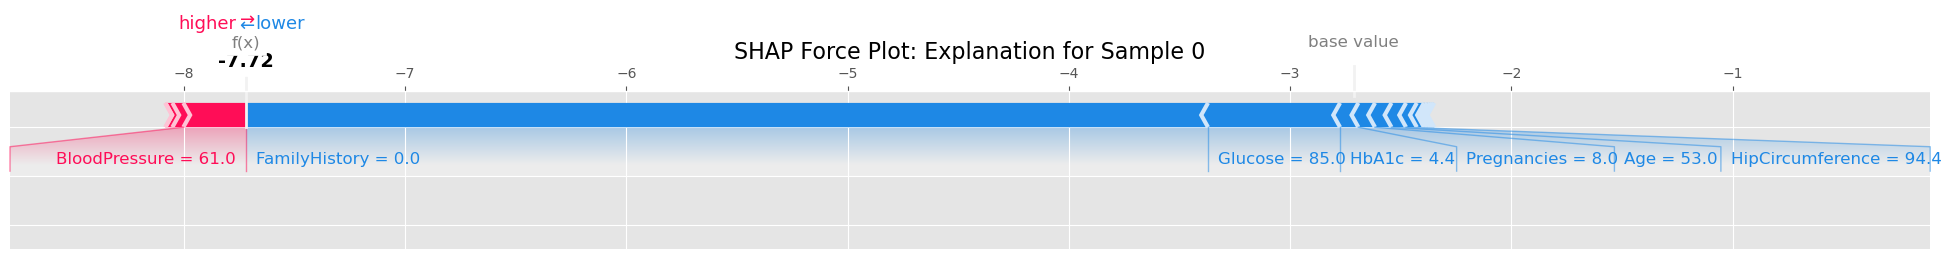

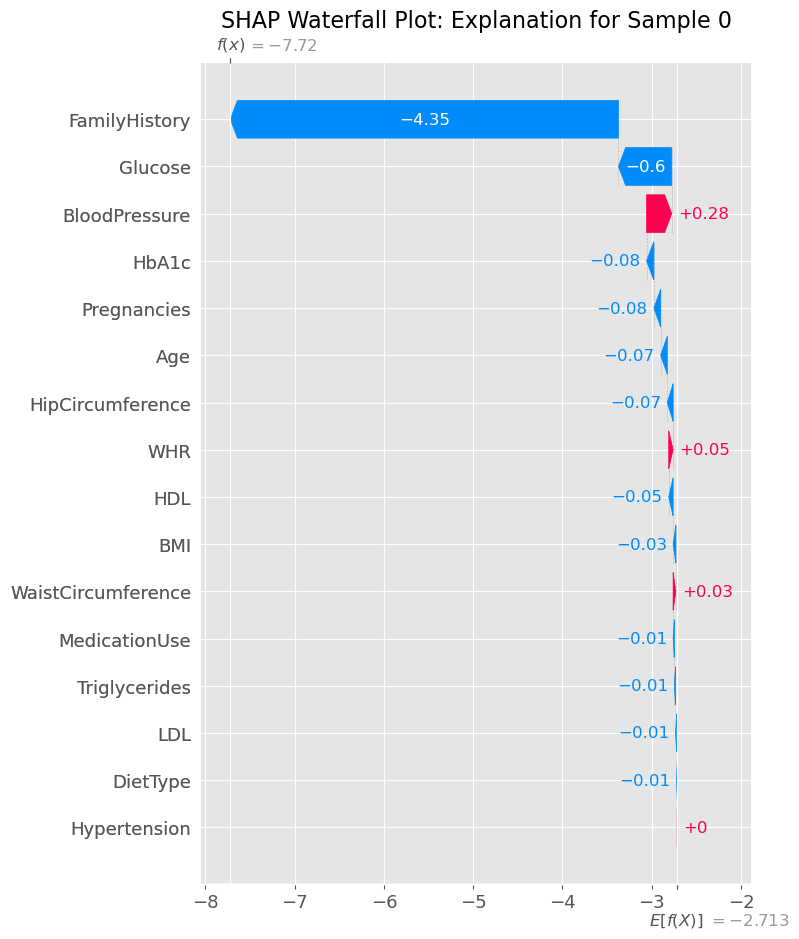

In [ ]:
explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_test)

sample_idx = 0  
sample = X_test.iloc[sample_idx]

shap.initjs()
shap.force_plot(
    explainer.expected_value,  # Base value (average prediction)
    shap_values[sample_idx, :],  # SHAP values for the sample
    sample,                     
    feature_names=X_test.columns,  
    matplotlib=True,             
    show=False                   
)

plt.title(f"SHAP Force Plot: Explanation for Sample {sample_idx}", fontsize=16)
plt.tight_layout()
plt.savefig(f"shap_force_plot_sample_{sample_idx}.png", dpi=300, bbox_inches='tight')
plt.show()

shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[sample_idx, :],
    feature_names=X_test.columns,
    max_display=17,  
    show=False
)
plt.title(f"SHAP Waterfall Plot: Explanation for Sample {sample_idx}", fontsize=16)
plt.tight_layout()
plt.savefig(f"shap_waterfall_plot_sample_{sample_idx}.png", dpi=300, bbox_inches='tight')
plt.show()

**SHAP Summary Plot, Bar Plot**

Generating SHAP Summary Plot...


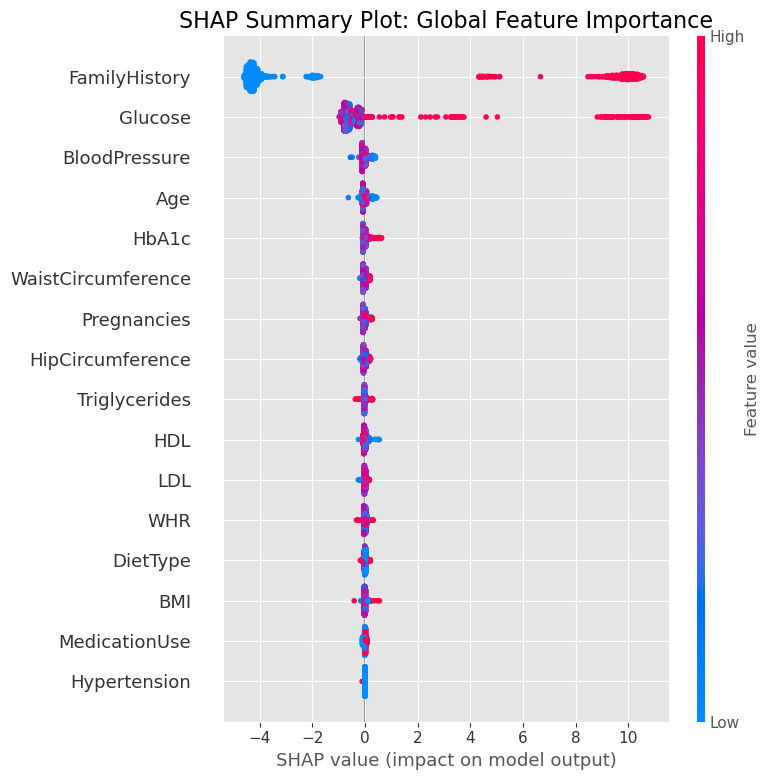

In [ ]:
explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(X_test)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (6, 4)

# 1. (Global Feature Importance)
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False)
plt.title("SHAP Summary Plot: Global Feature Importance", fontsize=16)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.show()

Generating SHAP Bar Plot...


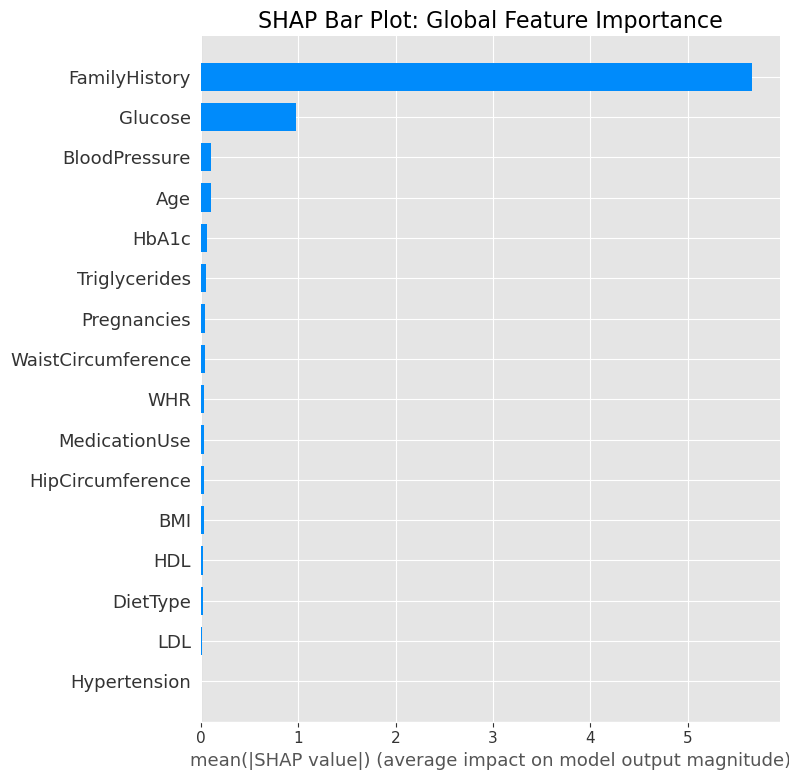

In [ ]:
print("Generating SHAP Bar Plot...")
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns, show=False)
plt.title("SHAP Bar Plot: Global Feature Importance", fontsize=16)
plt.tight_layout()
plt.savefig("shap_bar_plot.png", dpi=300, bbox_inches='tight')
plt.show()

**SHAP summary interaction plot for all features**

The top interaction is family history and glucose. Some features have near-zero SHAP interaction values (those features interact weakly with others).

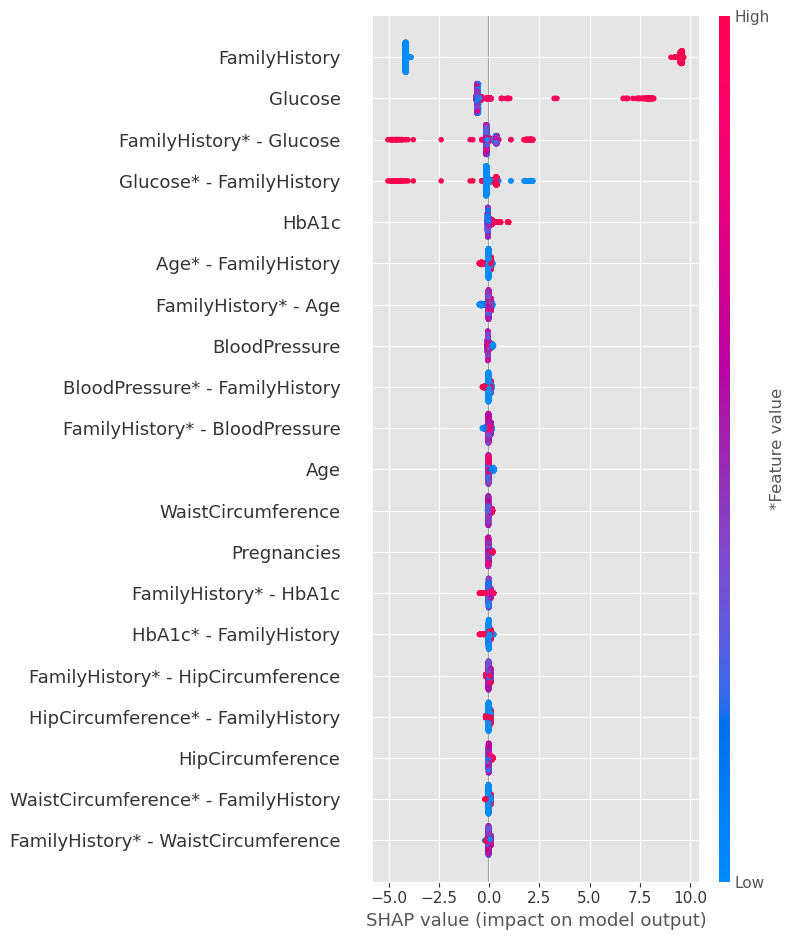

<Figure size 600x400 with 0 Axes>

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_interaction_values = explainer.shap_interaction_values(X_test)

plt.figure(figsize=(10, 6))  
shap.summary_plot(shap_interaction_values, X_test, plot_type="compact_dot")

plt.savefig("shap_interaction_summary_plot.png", dpi=300, bbox_inches='tight')
plt.show()